In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path
from tqdm import tqdm


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
#os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

import STG3Net as MODEL

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def get_data(proj_list, config):
    global graph_dict
    data_root = Path('../../data/DLPFC')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        ##### Load layer_guess label, if have
        truth_path = "../../data/DLPFC/" + proj_name + '/' + 'manual_annotations.txt'
        Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
        adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict

In [2]:
with open('Config/Config_DLPFC.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

proj_list = ['151673', '151674', '151675', '151676',
            '151507', '151508', '151509', '151510',
            '151669', '151670','151671', '151672']
num_cluster = 7

adata, graph_dict = get_data(proj_list, config['data'])

100%|██████████| 12/12 [01:21<00:00,  6.79s/it]


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [4]:
net.train(verbose=1)

Epoch 495 total loss=0.786 recon loss=0.794 tri loss=0.000 disc loss=2.304:  50%|████▉     | 499/1000 [00:23<00:21, 23.74it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 495 total loss=0.786 recon loss=0.794 tri loss=0.000 disc loss=2.304:  50%|████▉     | 499/1000 [00:35<00:21, 23.74it/s]

Processing datasets 151673 have 33107 nodes or edges
Processing datasets 151674 have 26479 nodes or edges
Processing datasets 151675 have 28028 nodes or edges
Processing datasets 151676 have 26505 nodes or edges
Processing datasets 151507 have 47770 nodes or edges
Processing datasets 151508 have 46990 nodes or edges
Processing datasets 151509 have 60825 nodes or edges
Processing datasets 151510 have 56668 nodes or edges
Processing datasets 151669 have 7928 nodes or edges
Processing datasets 151670 have 7789 nodes or edges
Processing datasets 151671 have 6418 nodes or edges
Processing datasets 151672 have 7418 nodes or edges


Epoch 545 total loss=1.154 recon loss=0.920 tri loss=0.278 disc loss=2.327:  55%|█████▌    | 550/1000 [02:24<00:31, 14.10it/s]  

fitting ...
  |======================================================================| 100%


Epoch 545 total loss=1.154 recon loss=0.920 tri loss=0.278 disc loss=2.327:  55%|█████▌    | 550/1000 [02:35<00:31, 14.10it/s]

Processing datasets 151673 have 69133 nodes or edges
Processing datasets 151674 have 64074 nodes or edges
Processing datasets 151675 have 63851 nodes or edges
Processing datasets 151676 have 60998 nodes or edges
Processing datasets 151507 have 77988 nodes or edges
Processing datasets 151508 have 78717 nodes or edges
Processing datasets 151509 have 92263 nodes or edges
Processing datasets 151510 have 90086 nodes or edges
Processing datasets 151669 have 56587 nodes or edges
Processing datasets 151670 have 51452 nodes or edges
Processing datasets 151671 have 57851 nodes or edges
Processing datasets 151672 have 58392 nodes or edges


Epoch 595 total loss=1.135 recon loss=0.885 tri loss=0.282 disc loss=2.328:  60%|██████    | 600/1000 [03:48<00:25, 15.59it/s]  

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=1.135 recon loss=0.885 tri loss=0.282 disc loss=2.328:  60%|██████    | 600/1000 [04:06<00:25, 15.59it/s]

Processing datasets 151673 have 69639 nodes or edges
Processing datasets 151674 have 68608 nodes or edges
Processing datasets 151675 have 66376 nodes or edges
Processing datasets 151676 have 64072 nodes or edges
Processing datasets 151507 have 78715 nodes or edges
Processing datasets 151508 have 79805 nodes or edges
Processing datasets 151509 have 95674 nodes or edges
Processing datasets 151510 have 88046 nodes or edges
Processing datasets 151669 have 59520 nodes or edges
Processing datasets 151670 have 50941 nodes or edges
Processing datasets 151671 have 65326 nodes or edges
Processing datasets 151672 have 62013 nodes or edges


Epoch 645 total loss=1.102 recon loss=0.873 tri loss=0.259 disc loss=2.315:  65%|██████▍   | 648/1000 [05:15<00:26, 13.49it/s]  

fitting ...
  |======================================================================| 100%


Epoch 645 total loss=1.102 recon loss=0.873 tri loss=0.259 disc loss=2.315:  65%|██████▍   | 648/1000 [05:26<00:26, 13.49it/s]

Processing datasets 151673 have 73203 nodes or edges
Processing datasets 151674 have 70943 nodes or edges
Processing datasets 151675 have 70033 nodes or edges
Processing datasets 151676 have 67773 nodes or edges
Processing datasets 151507 have 82216 nodes or edges
Processing datasets 151508 have 80079 nodes or edges
Processing datasets 151509 have 94119 nodes or edges
Processing datasets 151510 have 91183 nodes or edges
Processing datasets 151669 have 61638 nodes or edges
Processing datasets 151670 have 57865 nodes or edges
Processing datasets 151671 have 64976 nodes or edges
Processing datasets 151672 have 63655 nodes or edges


Epoch 695 total loss=1.077 recon loss=0.849 tri loss=0.251 disc loss=2.318:  70%|██████▉   | 699/1000 [06:41<00:19, 15.67it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 74980 nodes or edges


Epoch 695 total loss=1.077 recon loss=0.849 tri loss=0.251 disc loss=2.318:  70%|██████▉   | 699/1000 [06:56<00:19, 15.67it/s]

Processing datasets 151674 have 76400 nodes or edges
Processing datasets 151675 have 73782 nodes or edges
Processing datasets 151676 have 70882 nodes or edges
Processing datasets 151507 have 80862 nodes or edges
Processing datasets 151508 have 84254 nodes or edges
Processing datasets 151509 have 99357 nodes or edges
Processing datasets 151510 have 95767 nodes or edges
Processing datasets 151669 have 61955 nodes or edges
Processing datasets 151670 have 61793 nodes or edges
Processing datasets 151671 have 68366 nodes or edges
Processing datasets 151672 have 67488 nodes or edges


Epoch 745 total loss=1.051 recon loss=0.835 tri loss=0.234 disc loss=2.327:  75%|███████▍  | 748/1000 [07:59<00:17, 14.21it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 72254 nodes or edges


Epoch 745 total loss=1.051 recon loss=0.835 tri loss=0.234 disc loss=2.327:  75%|███████▍  | 748/1000 [08:16<00:17, 14.21it/s]

Processing datasets 151674 have 73885 nodes or edges
Processing datasets 151675 have 72219 nodes or edges
Processing datasets 151676 have 67920 nodes or edges
Processing datasets 151507 have 80009 nodes or edges
Processing datasets 151508 have 80237 nodes or edges
Processing datasets 151509 have 95138 nodes or edges
Processing datasets 151510 have 87992 nodes or edges
Processing datasets 151669 have 64469 nodes or edges
Processing datasets 151670 have 63272 nodes or edges
Processing datasets 151671 have 69680 nodes or edges
Processing datasets 151672 have 67418 nodes or edges


Epoch 795 total loss=1.064 recon loss=0.839 tri loss=0.245 disc loss=2.322:  80%|███████▉  | 798/1000 [09:15<00:12, 16.09it/s]

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=1.064 recon loss=0.839 tri loss=0.245 disc loss=2.322:  80%|███████▉  | 798/1000 [09:26<00:12, 16.09it/s]

Processing datasets 151673 have 77516 nodes or edges
Processing datasets 151674 have 77436 nodes or edges
Processing datasets 151675 have 76816 nodes or edges
Processing datasets 151676 have 71317 nodes or edges
Processing datasets 151507 have 82625 nodes or edges
Processing datasets 151508 have 85138 nodes or edges
Processing datasets 151509 have 99762 nodes or edges
Processing datasets 151510 have 96278 nodes or edges
Processing datasets 151669 have 66578 nodes or edges
Processing datasets 151670 have 63734 nodes or edges
Processing datasets 151671 have 75327 nodes or edges
Processing datasets 151672 have 73210 nodes or edges


Epoch 845 total loss=1.051 recon loss=0.828 tri loss=0.239 disc loss=2.325:  85%|████████▍ | 849/1000 [10:32<00:11, 13.71it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 76452 nodes or edges


Epoch 845 total loss=1.051 recon loss=0.828 tri loss=0.239 disc loss=2.325:  85%|████████▍ | 849/1000 [10:46<00:11, 13.71it/s]

Processing datasets 151674 have 75806 nodes or edges
Processing datasets 151675 have 74692 nodes or edges
Processing datasets 151676 have 70612 nodes or edges
Processing datasets 151507 have 84339 nodes or edges
Processing datasets 151508 have 85129 nodes or edges
Processing datasets 151509 have 99605 nodes or edges
Processing datasets 151510 have 94691 nodes or edges
Processing datasets 151669 have 68244 nodes or edges
Processing datasets 151670 have 65960 nodes or edges
Processing datasets 151671 have 72902 nodes or edges
Processing datasets 151672 have 72195 nodes or edges


Epoch 895 total loss=1.033 recon loss=0.822 tri loss=0.227 disc loss=2.306:  90%|████████▉ | 899/1000 [11:52<00:06, 15.49it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 77685 nodes or edges


Epoch 895 total loss=1.033 recon loss=0.822 tri loss=0.227 disc loss=2.306:  90%|████████▉ | 899/1000 [12:06<00:06, 15.49it/s]

Processing datasets 151674 have 76096 nodes or edges
Processing datasets 151675 have 76307 nodes or edges
Processing datasets 151676 have 71752 nodes or edges
Processing datasets 151507 have 85977 nodes or edges
Processing datasets 151508 have 88119 nodes or edges
Processing datasets 151509 have 99262 nodes or edges
Processing datasets 151510 have 95167 nodes or edges
Processing datasets 151669 have 70665 nodes or edges
Processing datasets 151670 have 66888 nodes or edges
Processing datasets 151671 have 76667 nodes or edges
Processing datasets 151672 have 74983 nodes or edges


Epoch 945 total loss=1.039 recon loss=0.820 tri loss=0.231 disc loss=2.339:  95%|█████████▍| 949/1000 [13:11<00:03, 16.58it/s]

fitting ...
  |======================================================================| 100%


Epoch 945 total loss=1.039 recon loss=0.820 tri loss=0.231 disc loss=2.339:  95%|█████████▍| 949/1000 [13:26<00:03, 16.58it/s]

Processing datasets 151673 have 71899 nodes or edges
Processing datasets 151674 have 69019 nodes or edges
Processing datasets 151675 have 67373 nodes or edges
Processing datasets 151676 have 65960 nodes or edges
Processing datasets 151507 have 85342 nodes or edges
Processing datasets 151508 have 86250 nodes or edges
Processing datasets 151509 have 89741 nodes or edges
Processing datasets 151510 have 85127 nodes or edges
Processing datasets 151669 have 63667 nodes or edges
Processing datasets 151670 have 60530 nodes or edges
Processing datasets 151671 have 79305 nodes or edges
Processing datasets 151672 have 73630 nodes or edges


Epoch 995 total loss=1.030 recon loss=0.815 tri loss=0.229 disc loss=2.308: 100%|██████████| 1000/1000 [14:35<00:00,  1.14it/s]


In [5]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
print(adata)

AnnData object with n_obs × n_vars = 47329 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'slice_id', 'layer_guess', 'proj_name', 'batch', 'Tmp_domain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'latent', 'recon'
    layers: 'count'


In [6]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


In [7]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")


total ARI:0.41721848848493415
151673 ARI:0.5641065666389756
151674 ARI:0.5872487435626966
151675 ARI:0.5662907038694582
151676 ARI:0.5669060173846754
151507 ARI:0.5181495383301588
151508 ARI:0.5264683559202942
151509 ARI:0.48597414068860767
151510 ARI:0.48199865470316666
151669 ARI:0.3973275905632439
151670 ARI:0.3826256143754896
151671 ARI:0.3888452300287909
151672 ARI:0.4641184971875335


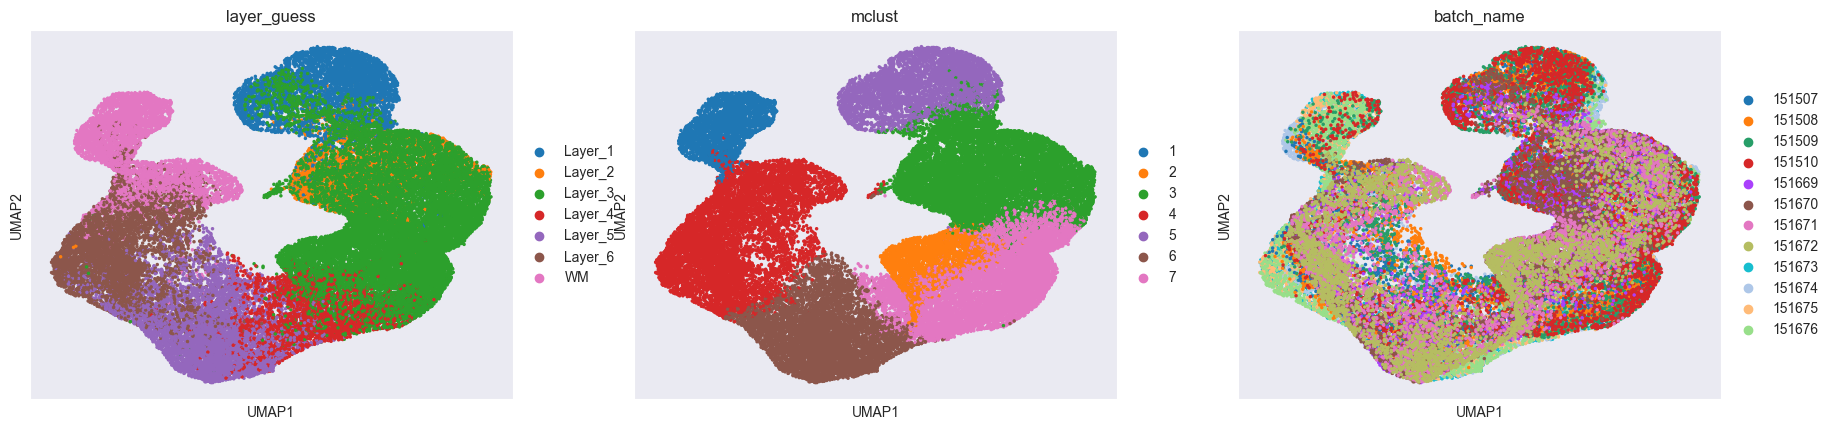

In [8]:
# %%
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'batch_name'], show=True, size=25, save=False)

In [9]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = MODEL.compute_ARI(sub_adata, f'layer_guess', f'mclust')
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = MODEL.compute_ARI(sub_adata_tmp, f'layer_guess', f'mclust')
    print(f"{ARI}")

total ARI:0.41721848848493415
0.5641065666389756
0.5872487435626966
0.5662907038694582
0.5669060173846754
0.5181495383301588
0.5264683559202942
0.48597414068860767
0.48199865470316666
0.3973275905632439
0.3826256143754896
0.3888452300287909
0.4641184971875335


In [10]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
NMI = MODEL.compute_NMI(sub_adata, f'layer_guess', f'mclust')
print(f"total NMI:{NMI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    NMI = MODEL.compute_NMI(sub_adata_tmp, f'layer_guess', f'mclust')
    print(f"{NMI}")

total NMI:0.6064418644957763
0.6993539014305029
0.7186799690357534
0.6942498729794526
0.6923559370070673
0.6674646548968199
0.6684495370101787
0.6635334604469751
0.6569826397717842
0.5636956494197026
0.5310170734803273
0.5845194758768153
0.6146317963322464


In [11]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
HOM = MODEL.compute_HOM(sub_adata, f'layer_guess', f'mclust')
print(f"total HOM:{HOM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    HOM = MODEL.compute_HOM(sub_adata_tmp, f'layer_guess', f'mclust')
    print(f"{HOM}")

total HOM:0.6184671195532028
0.6795820064272166
0.693223768018962
0.6652779419691537
0.6698577128125506
0.636893061993969
0.6441685139170151
0.6448192889052872
0.6378157775968739
0.6616041894587804
0.6493965374587315
0.6315962687917366
0.6414964058578012


In [12]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
COM = MODEL.compute_COM(sub_adata, f'layer_guess', f'mclust')
print(f"total COM:{COM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    COM = MODEL.compute_COM(sub_adata_tmp, f'layer_guess', f'mclust')
    print(f"{COM}")

total COM:0.5948753200112903
0.7203107671556755
0.7460770195403882
0.725860071653452
0.7164179602987049
0.701119174399709
0.6946327378087421
0.6833663585627774
0.6773371500504057
0.49102982577043824
0.44914226050842304
0.5439737346750156
0.5899268197845264


In [13]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
CHAOS = MODEL.compute_CHAOS(sub_adata, f'mclust')
print(f"total CHAOS:{CHAOS}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    CHAOS = MODEL.compute_CHAOS(sub_adata_tmp, f'mclust')
    print(f"{CHAOS}")

total CHAOS:0.01587514480078091
0.06067970333034458
0.05989671156496884
0.06054706177000196
0.06250516138005509
0.056713439204144206
0.05583676330322813
0.053806153260762844
0.05545507693333167
0.06294200159526205
0.061929241423599464
0.0585334057165984
0.06021711455310875


In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
PAS = MODEL.compute_PAS(sub_adata, f'mclust')
print(f"total PAS:{PAS}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    PAS = MODEL.compute_PAS(sub_adata_tmp, f'mclust')
    print(f"{PAS}")

In [ ]:
import harmonypy as hm

def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    num_domains = len(set(Tmp_adata.obs[PD_key])) - 1
    num_batchs = len(set(Tmp_adata.obs[BT_key])) - 1
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]
    norm_batch = (LISI_batch_norm - 1)/num_batchs
    norm_domain = (LISI_domain_norm - 1)/num_domains
    LISI = 2*(1-norm_domain)*norm_batch / (1-norm_domain+norm_batch)
    return LISI , norm_batch, norm_domain

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
LISI , norm_batch, norm_domain = compute_fscoreLISI(sub_adata, 'latent', 'batch_name', 'layer_guess')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_batch_norm = pd.DataFrame({
    'method': 'STG3Net',
    'value': norm_batch,
    'type': ['batch_norm'] * len(norm_batch)
})

df_domain_norm = pd.DataFrame({
    'method': 'STG3Net',
    'value': norm_domain,
    'type': ['domain_norm'] * len(norm_domain)
})

df_F1LISI = pd.DataFrame({
    'method': 'STG3Net',
    'value': LISI,
    'type': ['F1LISI'] * len(LISI)
})

fig, axes = plt.subplots(1, 3, figsize=(6, 5))
sns.boxplot(data=df_batch_norm, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_domain_norm, x='method', y='value', ax=axes[1])
sns.boxplot(data=df_F1LISI, x='method', y='value', ax=axes[2])
axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)
axes[0].set_title('batch_norm')
axes[1].set_title('domain_norm')
axes[2].set_title('F1LISI')
plt.tight_layout()

In [ ]:
np.median(LISI)

In [ ]:
Batch_list = []
for section_id in proj_list:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['layer_guess'], Batch_list[bb].obs['mclust']), 3))


In [ ]:

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                      spot_size=spot_size)
    _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)
plt.show()